In [2]:
!pip install opencv-python scikit-image
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [3]:
import cv2
import numpy as np
import os
from skimage.metrics import structural_similarity
from google.colab import files
import torch
import pandas as pd
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt


In [4]:
from google.colab import files
uploaded = files.upload()

Saving chuluu_bichleg.mp4 to chuluu_bichleg.mp4


In [5]:
# Try to import SamAutomaticMaskGenerator, fall back if not available
try:
    from segment_anything import SamAutomaticMaskGenerator
    automatic_mask_generator_available = True
except ImportError:
    print("⚠️ Warning: SamAutomaticMaskGenerator is not available. Falling back to predictor.predict.")
    automatic_mask_generator_available = False

In [6]:
# Set up directories and download SAM checkpoint
HOME = os.getcwd()
WEIGHTS_DIR = os.path.join(HOME, "weights")
CHECKPOINT_PATH = os.path.join(WEIGHTS_DIR, "sam_vit_h_4b8939.pth")
os.makedirs(WEIGHTS_DIR, exist_ok=True)

In [7]:
if not os.path.isfile(CHECKPOINT_PATH):
    os.system(f"wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {WEIGHTS_DIR}")


In [8]:
# Initialize SAM model
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
predictor = SamPredictor(sam)

In [16]:
def extract_frames(video_path, output_folder, capture_interval=1, default_fps=30):
    """Extract frames from a video at specified intervals."""
    if not os.path.isfile(video_path):
        print(f"❌ Error: Video file {video_path} does not exist.")
        return 0

    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error: Could not open video file {video_path}. Check if the file is corrupted or in a supported format.")
        return 0

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if fps <= 0:
        print(f"⚠️ Warning: Invalid FPS ({fps}) for video {video_path}. Using default FPS of {default_fps}.")
        fps = default_fps

    duration = total_frames / fps
    print(f"✅ FPS: {fps}")
    print(f"📽 Total frames: {total_frames}")
    print(f"⏱ Duration: {duration:.2f} seconds")

    frame_index = 0
    saved_count = 0
    next_capture_time = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        current_time = frame_index / fps
        if current_time >= next_capture_time:
            filename = os.path.join(output_folder, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1
            next_capture_time += capture_interval
        frame_index += 1

    cap.release()
    print(f"✅ Saved {saved_count} frames.")
    return saved_count

def order_points(pts):
    """Order contour points to form a rectangle: top-left, top-right, bottom-right, bottom-left."""
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

def warp_green_frame(image, real_green_width_mm=350, real_green_height_mm=180):
    """Detect and warp green frame to align image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 50, 50])
    upper_green = np.array([80, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((9, 9), np.uint8)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)
    green_mask = cv2.dilate(green_mask, kernel, iterations=1)
    green_mask = cv2.erode(green_mask, kernel, iterations=1)

    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    largest = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(largest, True)
    approx = cv2.approxPolyDP(largest, epsilon, True)

    if len(approx) != 4:
        return None

    rect = order_points(approx.reshape(4, 2))
    widthA = np.linalg.norm(rect[2] - rect[3])
    widthB = np.linalg.norm(rect[1] - rect[0])
    heightA = np.linalg.norm(rect[1] - rect[2])
    heightB = np.linalg.norm(rect[0] - rect[3])
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))

    # Scale up image size to increase mask area
    maxWidth = int(maxWidth * 2)
    maxHeight = int(maxHeight * 2)

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def compute_iou_and_filter(masks):
    """Compute IoU between all mask pairs, filter based on IoU and area criteria."""
    # First, filter masks with area < 4000 pixels
    filtered_masks = [mask for mask in masks if np.sum(mask) >= 4000]
    print(f"After area filter (≥ 4000 pixels), {len(filtered_masks)} masks remain.")

    if len(filtered_masks) == 0:
        return []

    # Compute areas for remaining masks
    areas = [np.sum(mask) for mask in filtered_masks]

    # Compute IoU and filter based on criteria
    indices_to_remove = set()
    for i in range(len(filtered_masks)):
        for j in range(i + 1, len(filtered_masks)):
            if i in indices_to_remove or j in indices_to_remove:
                continue

            # Compute IoU
            intersection = np.logical_and(filtered_masks[i], filtered_masks[j])
            union = np.logical_or(filtered_masks[i], filtered_masks[j])
            iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

            if iou >= 0.85:  # IoU >= 85%
                area_i = areas[i]
                area_j = areas[j]

                # Compute area difference percentage
                if area_i > area_j:
                    area_diff_percent = (area_i - area_j) / area_j * 100
                    larger_idx, smaller_idx = i, j
                else:
                    area_diff_percent = (area_j - area_i) / area_i * 100
                    larger_idx, smaller_idx = j, i

                if area_diff_percent > 90:  # Area difference > 90%
                    # Remove the mask with larger area
                    indices_to_remove.add(larger_idx)
                else:
                    # Remove the first mask (arbitrary choice)
                    indices_to_remove.add(i)

    # Keep masks that are not in indices_to_remove
    final_masks = [mask for idx, mask in enumerate(filtered_masks) if idx not in indices_to_remove]
    print(f"After IoU filter (IoU ≥ 0.85), {len(final_masks)} masks remain.")

    return final_masks

def compute_mask_overlap(masks):
    """Compute total overlap (intersection) area in pixels for each mask with all other masks."""
    overlaps = []
    for i, mask_i in enumerate(masks):
        total_overlap = 0
        for j, mask_j in enumerate(masks):
            if i != j:
                intersection = np.logical_and(mask_i, mask_j)
                total_overlap += np.sum(intersection)
        overlaps.append(total_overlap)
    return overlaps

def process_and_measure_sam_masks(image, masks, pixel_to_mm_ratio_width, pixel_to_mm_ratio_height, image_name=""):
    """Process SAM masks, measure geometric properties, classify shapes, and save visualizations."""
    print(f"Generated {len(masks)} raw masks for {image_name}")

    for i, mask in enumerate(masks):
        area = np.sum(mask)
        print(f"Mask {i + 1} area: {area} pixels")

    # Apply IoU and area filtering
    filtered_masks = compute_iou_and_filter(masks)

    mask_output_folder = "/content/masks"
    os.makedirs(mask_output_folder, exist_ok=True)

    overlaps = compute_mask_overlap(filtered_masks)

    results = []
    for mask_id, (mask, overlap_pixels) in enumerate(zip(filtered_masks, overlaps)):
        area_pixels = np.sum(mask)

        masked_image = image * mask[:, :, np.newaxis]
        mean_color = np.mean(masked_image[mask], axis=0)
        r, g, b = mean_color if len(mean_color) == 3 else (0, 0, 0)

        mask_img = (mask * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(contour) < 2:
            continue

        area_pixels = cv2.contourArea(contour)
        perimeter_pixels = cv2.arcLength(contour, True)
        min_rect = cv2.minAreaRect(contour)
        (center_x, center_y), (width_pixels, height_pixels), angle = min_rect
        if abs(angle) > 45:
            width_pixels, height_pixels = height_pixels, width_pixels

        effective_diameter_pixels = np.sqrt(4 * area_pixels / np.pi) if area_pixels > 0 else 0
        area_mm = area_pixels * pixel_to_mm_ratio_width * pixel_to_mm_ratio_height
        perimeter_mm = perimeter_pixels * pixel_to_mm_ratio_width
        width_mm = width_pixels * pixel_to_mm_ratio_width
        height_mm = height_pixels * pixel_to_mm_ratio_height
        effective_diameter_mm = effective_diameter_pixels * pixel_to_mm_ratio_width

        shape_ratio = min(width_pixels, height_pixels) / max(width_pixels, height_pixels) if max(width_pixels, height_pixels) > 0 else 0
        circularity = (4 * np.pi * area_pixels) / (perimeter_pixels ** 2) if perimeter_pixels > 0 else 0

        if circularity > 0.85 and shape_ratio > 0.9:
            shape_type = "Дугуй"
        elif circularity > 0.6 and shape_ratio > 0.5:
            shape_type = "Зууван"
        elif shape_ratio < 0.5:
            shape_type = "Сунгасан"
        else:
            shape_type = "Барзгар / Тогтворгүй хэлбэр"

        vis_image = image.copy()
        color = np.random.randint(0, 255, size=3).tolist()
        vis_image[mask] = vis_image[mask] * 0.5 + np.array(color) * 0.5
        cv2.drawContours(vis_image, [contour], -1, color, 2)
        cv2.putText(vis_image, f"Mask {mask_id + 1}", (int(center_x), int(center_y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        vis_filename = os.path.join(mask_output_folder, f"{image_name}_mask_{mask_id + 1}.jpg")
        cv2.imwrite(vis_filename, vis_image)

        results.append({
            "image": image_name,
            "mask_id": mask_id + 1,
            "area_pixels": area_pixels,
            "area_mm2": area_mm,
            "perimeter_pixels": perimeter_pixels,
            "perimeter_mm": perimeter_mm,
            "width_pixels": width_pixels,
            "width_mm": width_mm,
            "height_pixels": height_pixels,
            "height_mm": height_mm,
            "effective_diameter_pixels": effective_diameter_pixels,
            "effective_diameter_mm": effective_diameter_mm,
            "shape_type": shape_type,
            "circularity": circularity,
            "shape_ratio": shape_ratio,
            "overlap_pixels": overlap_pixels
        })

    return results

def plot_distributions_for_csv(csv_path, output_folder):
    """Plot distributions for a single CSV file."""
    df = pd.read_csv(csv_path)
    if df.empty:
        print(f"⚠️ CSV file {csv_path} is empty.")
        return

    # Number of rocks (masks)
    num_rocks = len(df)
    image_name = os.path.splitext(os.path.basename(csv_path))[0]

    # Create a directory for plots for this image
    plot_folder = os.path.join(output_folder, f"{image_name}_plots")
    os.makedirs(plot_folder, exist_ok=True)

    # 1. Shape Type Distribution (Bar Chart)
    plt.figure(figsize=(10, 6))
    shape_counts = df['shape_type'].value_counts()
    shape_counts.plot(kind='bar')
    plt.title(f'Distribution of Shape Types for {image_name}')
    plt.xlabel('Shape Type')
    plt.ylabel('Count')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'shape_type_distribution.png'))
    plt.show()
    plt.close()

    # 2. Width Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['width_pixels'], bins=20, edgecolor='black')
    plt.title(f'Distribution of Width (Pixels) for {image_name}')
    plt.xlabel('Width (Pixels)')
    plt.ylabel('Frequency')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'width_distribution.png'))
    plt.show()
    plt.close()

    # 3. Height Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['height_pixels'], bins=20, edgecolor='black')
    plt.title(f'Distribution of Height (Pixels) for {image_name}')
    plt.xlabel('Height (Pixels)')
    plt.ylabel('Frequency')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'height_distribution.png'))
    plt.show()
    plt.close()

    # 4. Perimeter Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['perimeter_pixels'], bins=20, edgecolor='black')
    plt.title(f'Distribution of Perimeter (Pixels) for {image_name}')
    plt.xlabel('Perimeter (Pixels)')
    plt.ylabel('Frequency')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'perimeter_distribution.png'))
    plt.show()
    plt.close()

    # 5. Area Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['area_pixels'], bins=20, edgecolor='black')
    plt.title(f'Distribution of Area (Pixels) for {image_name}')
    plt.xlabel('Area (Pixels)')
    plt.ylabel('Frequency')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'area_distribution.png'))
    plt.show()
    plt.close()

    # 6. Effective Diameter Distribution (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['effective_diameter_pixels'], bins=20, edgecolor='black')
    plt.title(f'Distribution of Effective Diameter (Pixels) for {image_name}')
    plt.xlabel('Effective Diameter (Pixels)')
    plt.ylabel('Frequency')
    plt.text(0.95, 0.95, f'Чулууны тоо: {num_rocks}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig(os.path.join(plot_folder, 'effective_diameter_distribution.png'))
    plt.show()
    plt.close()


✅ Google Drive is already mounted.
✅ FPS: 29.824406600194123
📽 Total frames: 507
⏱ Duration: 17.00 seconds
✅ Saved 17 frames.
⚠️ frame_0002.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0003.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0004.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0005.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0006.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0007.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0008.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0009.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0011.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0014.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0015.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
⚠️ frame_0016.jpg дээр ногоон хүрээ илрээгүй тул хадгалаагүй.
✅ Нийт 5/17 зураг тэгшлээд хадгаллаа.
📸 Total images to process in aligned_folder: 5
🔄 Processing image 1/5: aligned_0000.jpg
Gene

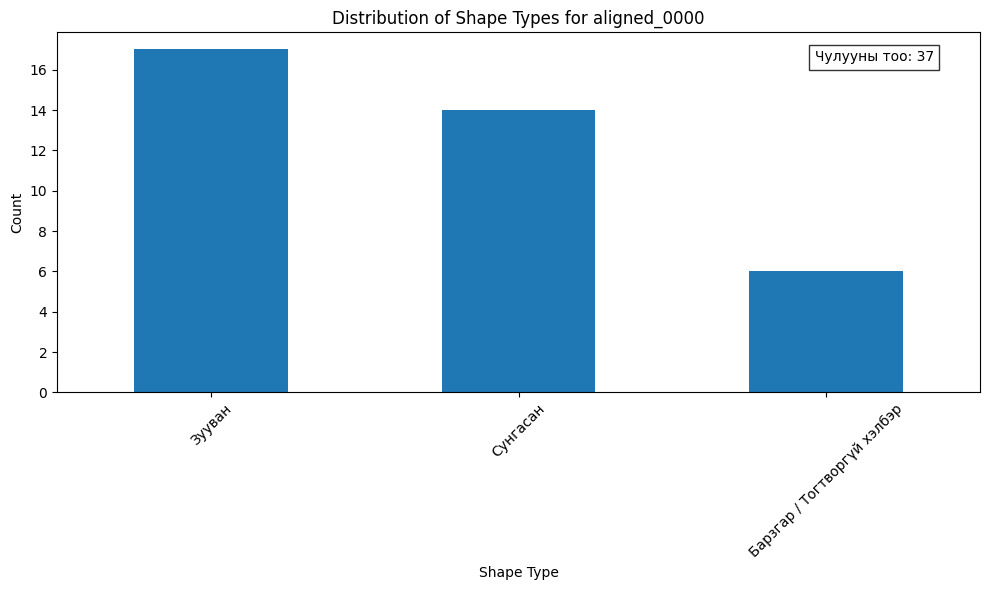

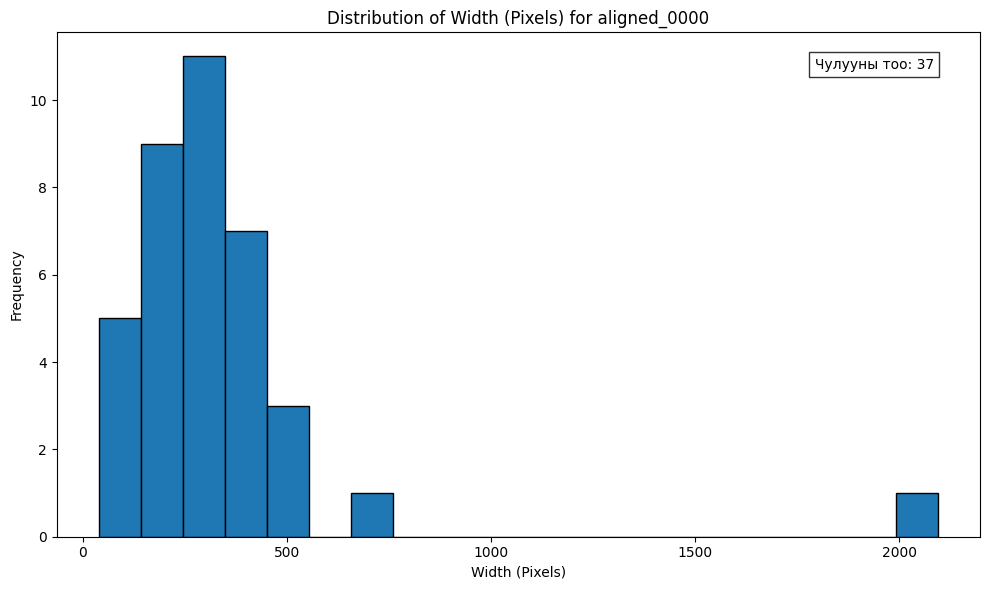

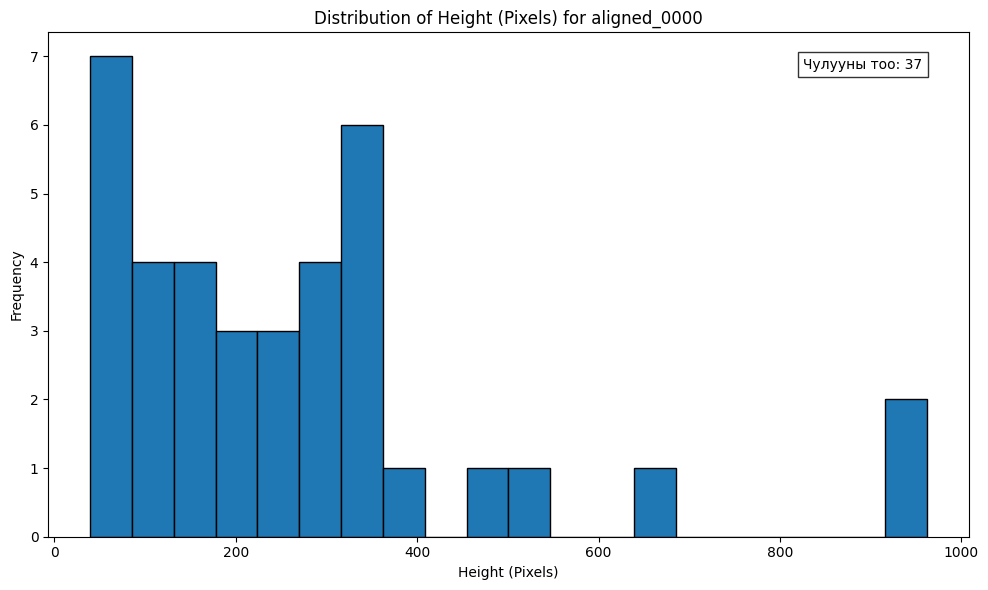

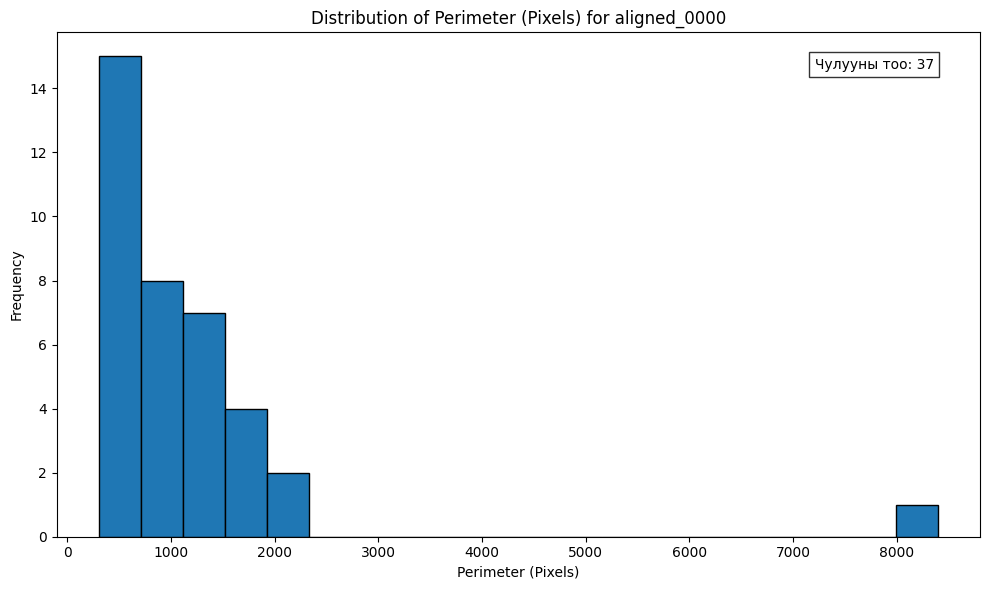

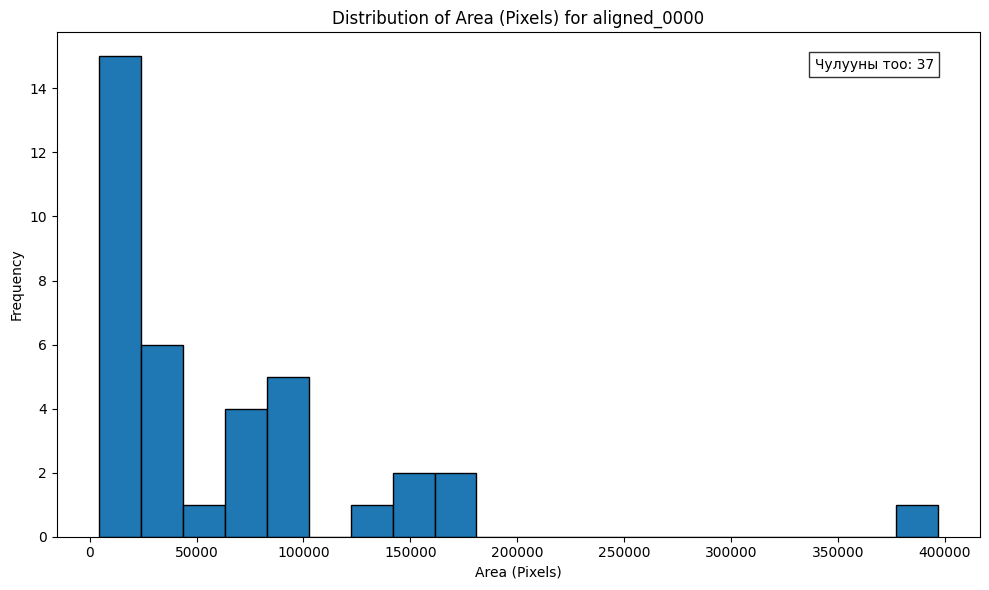

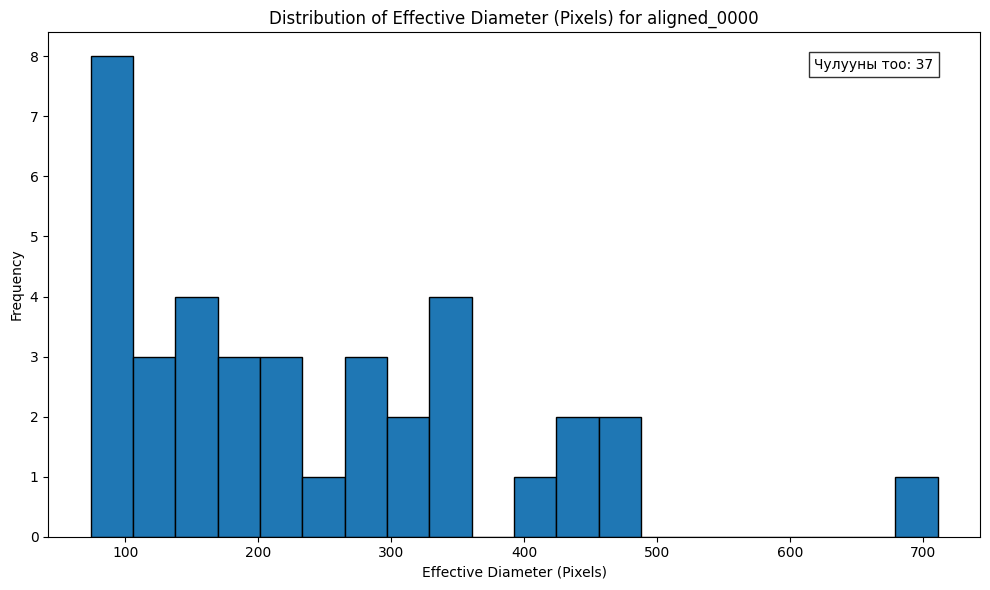

❌ Error processing aligned_0000.jpg: name 'gc' is not defined
🔄 Processing image 2/5: aligned_0001.jpg
Generated 73 raw masks for aligned_0001.jpg
Mask 1 area: 76280 pixels
Mask 2 area: 90998 pixels
Mask 3 area: 173982 pixels
Mask 4 area: 87955 pixels
Mask 5 area: 175104 pixels
Mask 6 area: 69517 pixels
Mask 7 area: 175611 pixels
Mask 8 area: 175537 pixels
Mask 9 area: 91433 pixels
Mask 10 area: 52483 pixels
Mask 11 area: 86421 pixels
Mask 12 area: 76091 pixels
Mask 13 area: 70685 pixels
Mask 14 area: 175698 pixels
Mask 15 area: 93279 pixels
Mask 16 area: 416669 pixels
Mask 17 area: 76275 pixels
Mask 18 area: 26402 pixels
Mask 19 area: 164864 pixels
Mask 20 area: 176840 pixels
Mask 21 area: 36167 pixels
Mask 22 area: 52639 pixels
Mask 23 area: 85050 pixels
Mask 24 area: 86357 pixels
Mask 25 area: 34807 pixels
Mask 26 area: 25001 pixels
Mask 27 area: 128048 pixels
Mask 28 area: 128063 pixels
Mask 29 area: 15494 pixels
Mask 30 area: 100826 pixels
Mask 31 area: 93763 pixels
Mask 32 area: 

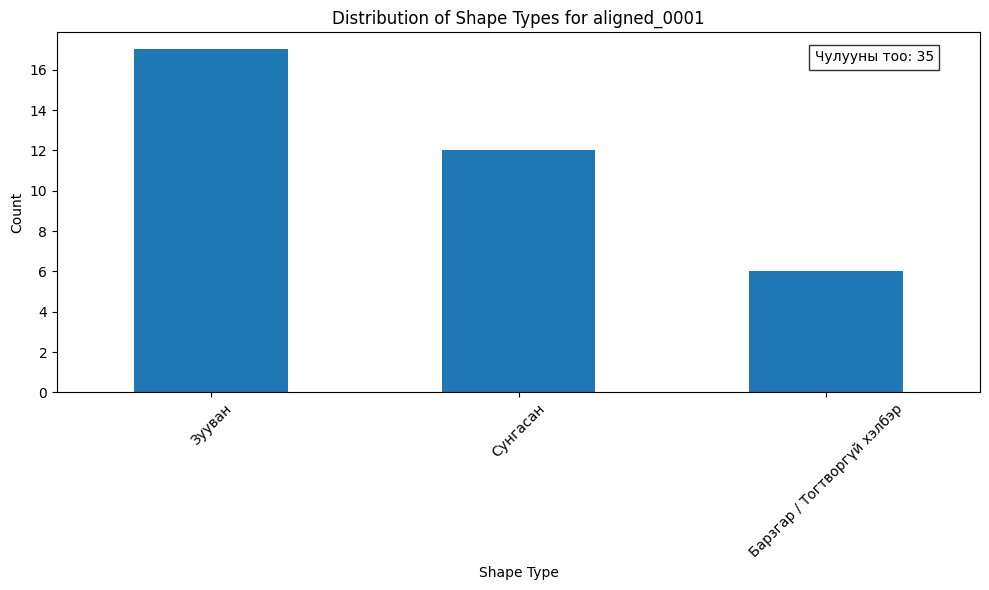

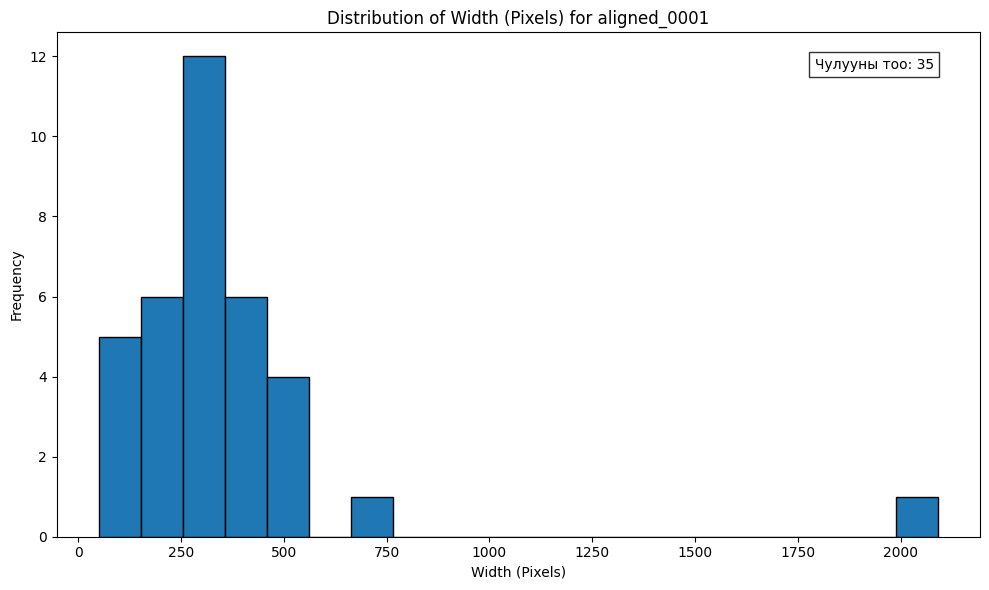

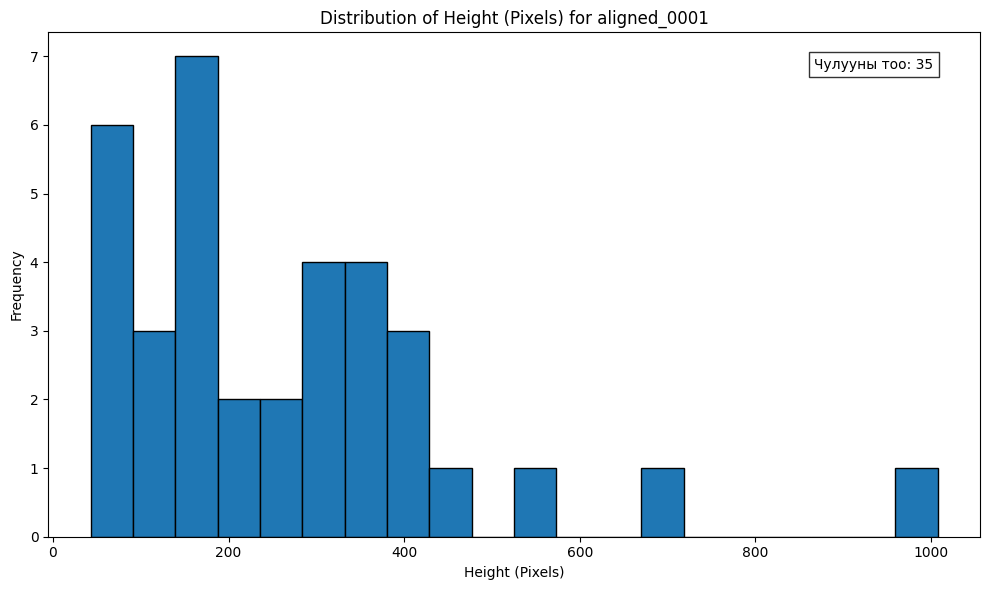

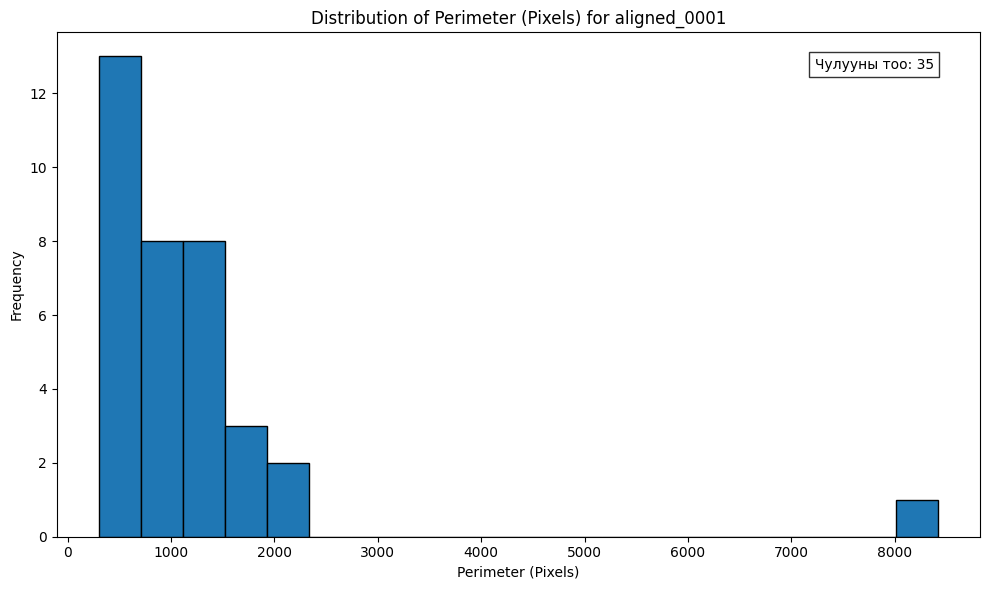

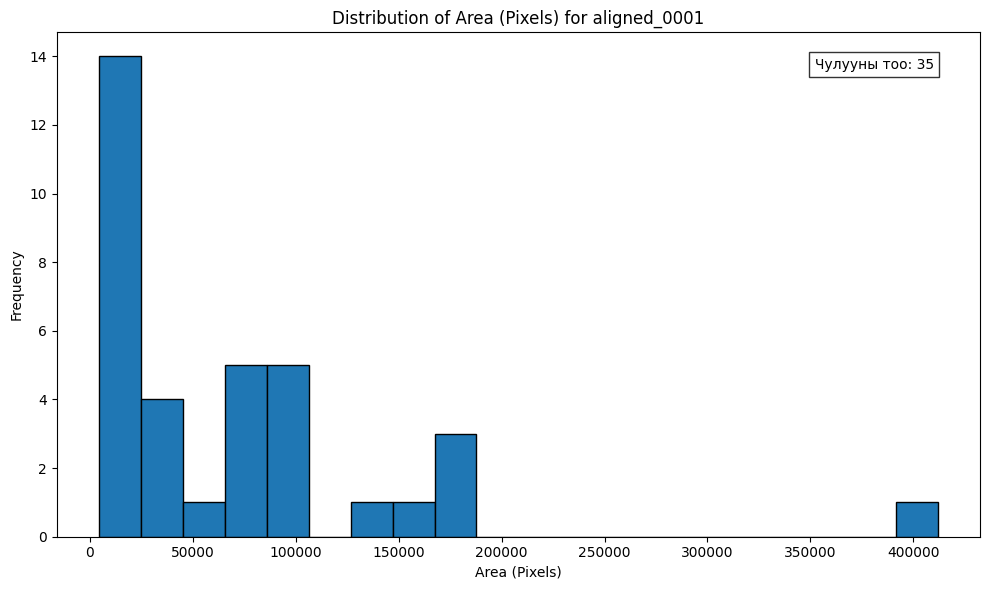

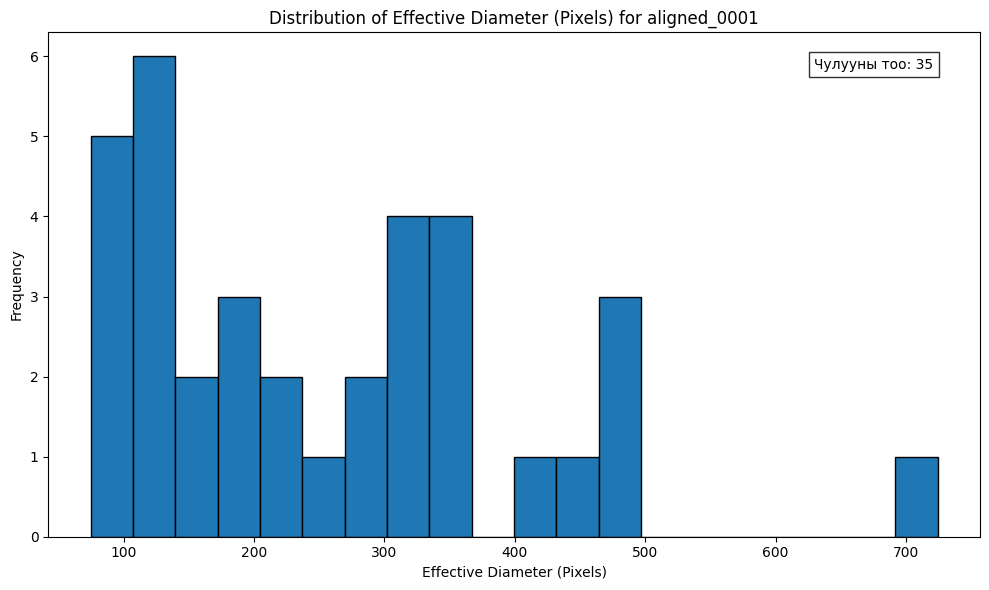

❌ Error processing aligned_0001.jpg: name 'gc' is not defined
🔄 Processing image 3/5: aligned_0010.jpg
Generated 66 raw masks for aligned_0010.jpg
Mask 1 area: 78749 pixels
Mask 2 area: 62790 pixels
Mask 3 area: 80915 pixels
Mask 4 area: 76436 pixels
Mask 5 area: 60768 pixels
Mask 6 area: 155070 pixels
Mask 7 area: 67490 pixels
Mask 8 area: 154887 pixels
Mask 9 area: 437871 pixels
Mask 10 area: 61820 pixels
Mask 11 area: 43721 pixels
Mask 12 area: 24017 pixels
Mask 13 area: 145255 pixels
Mask 14 area: 93302 pixels
Mask 15 area: 146362 pixels
Mask 16 area: 113141 pixels
Mask 17 area: 32776 pixels
Mask 18 area: 147036 pixels
Mask 19 area: 27513 pixels
Mask 20 area: 28682 pixels
Mask 21 area: 22912 pixels
Mask 22 area: 67668 pixels
Mask 23 area: 14960 pixels
Mask 24 area: 80507 pixels
Mask 25 area: 121903 pixels
Mask 26 area: 146387 pixels
Mask 27 area: 9542 pixels
Mask 28 area: 122251 pixels
Mask 29 area: 13699 pixels
Mask 30 area: 62281 pixels
Mask 31 area: 10950 pixels
Mask 32 area: 81

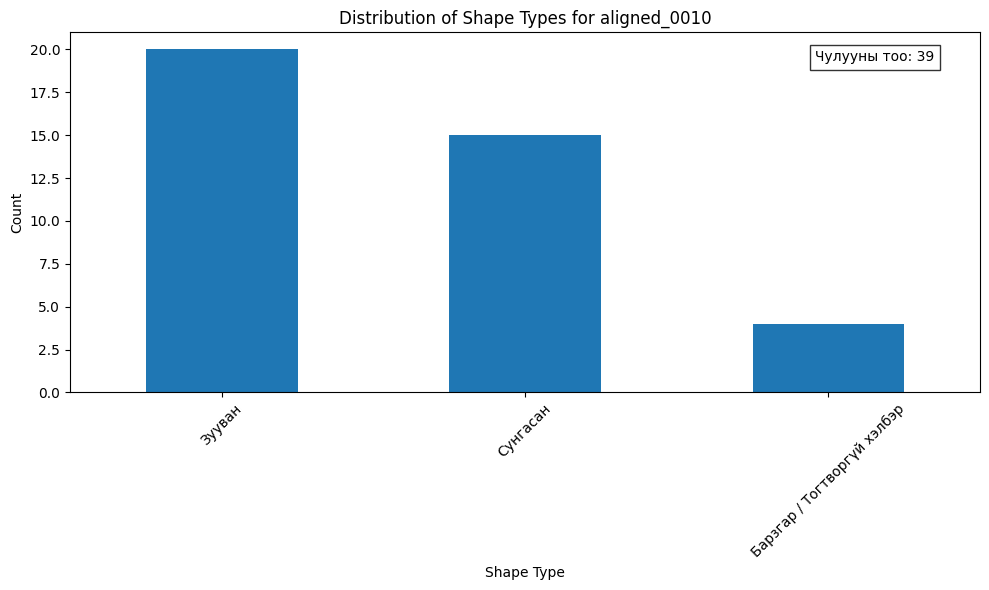

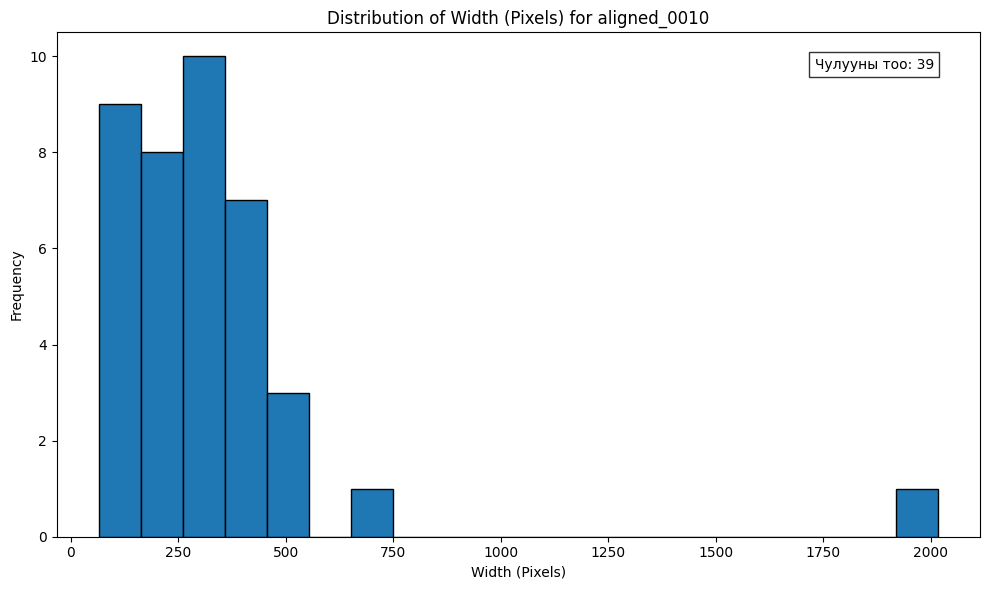

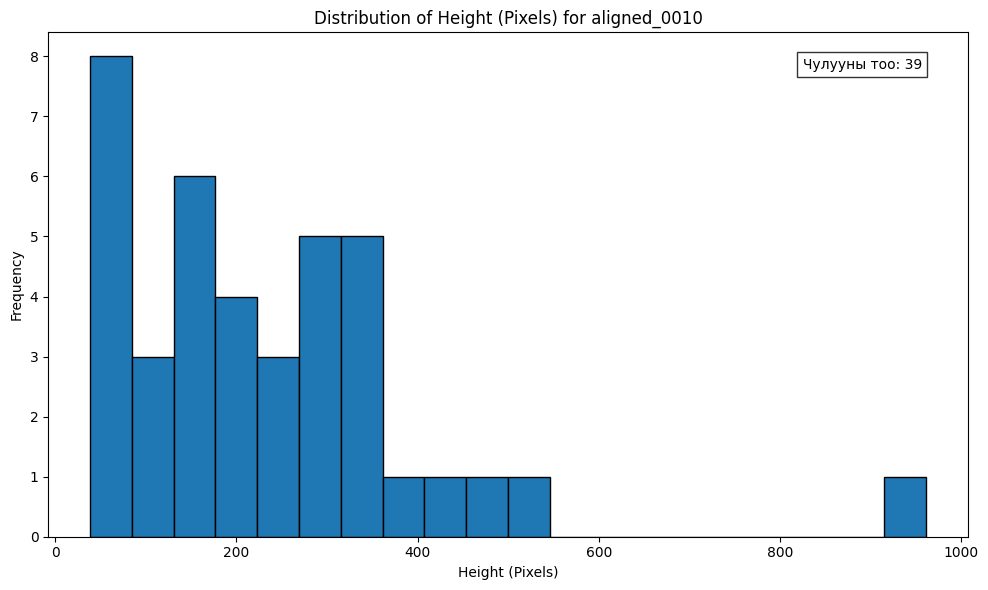

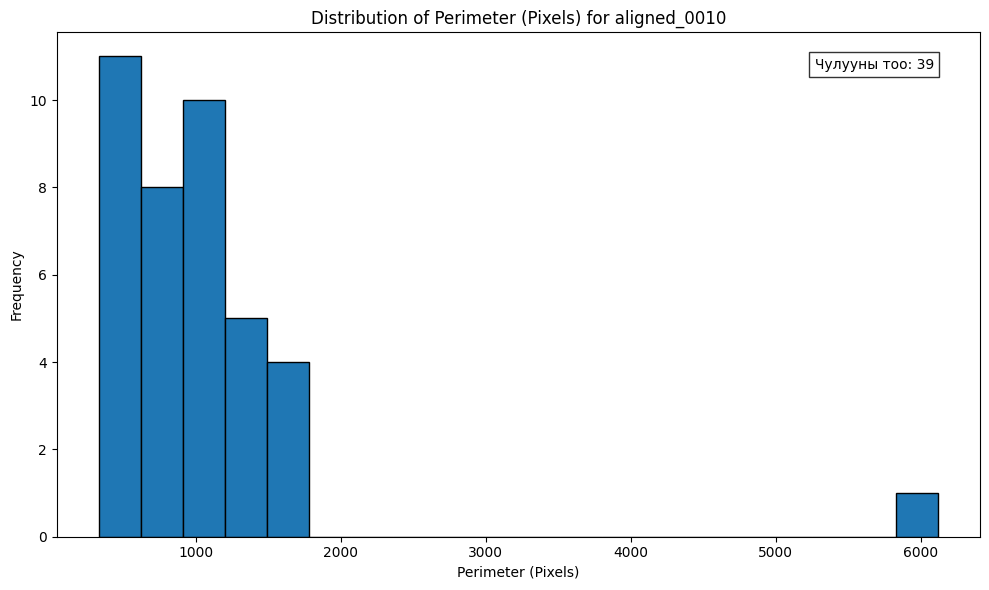

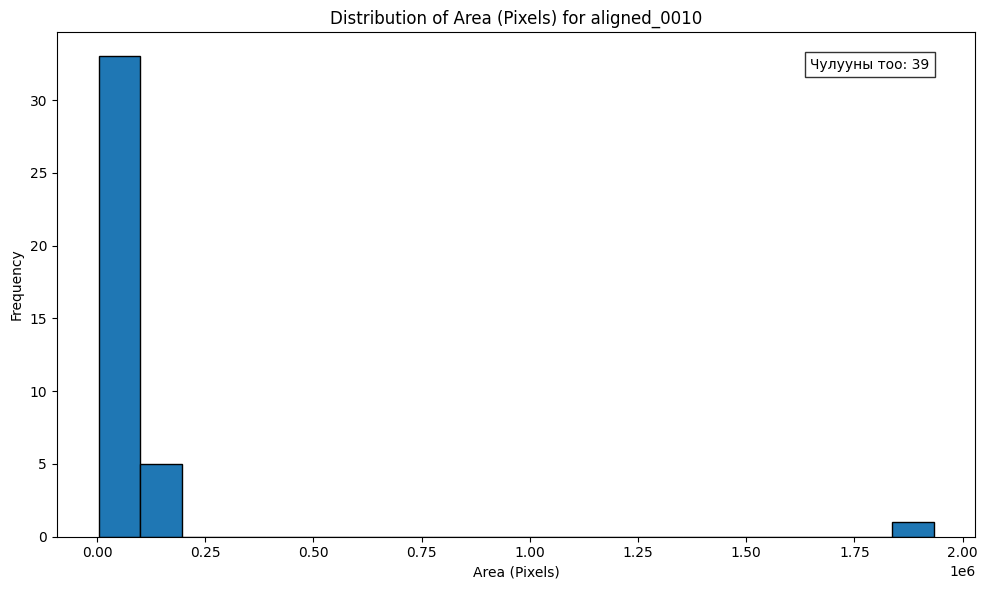

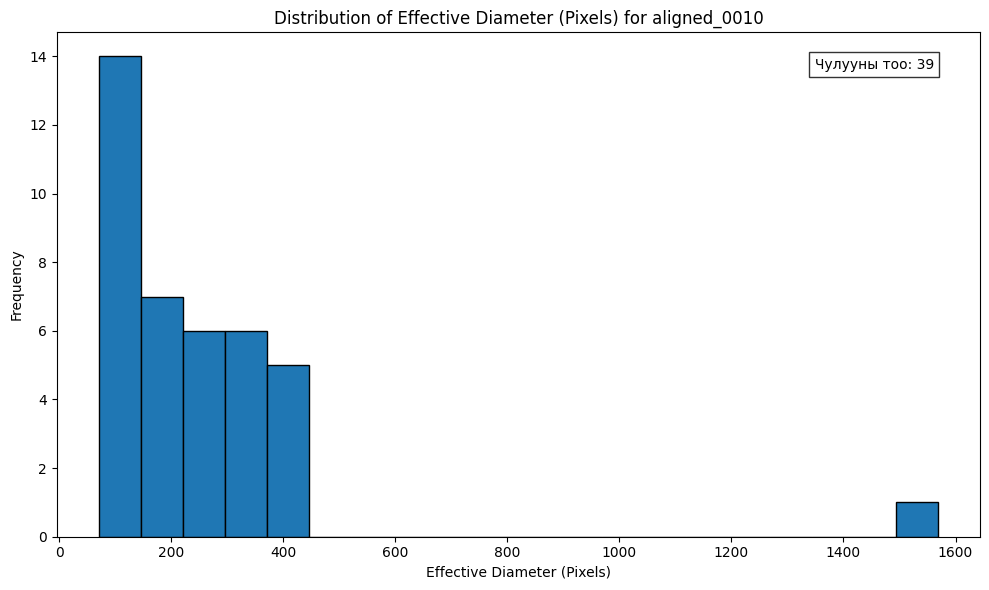

❌ Error processing aligned_0010.jpg: name 'gc' is not defined
🔄 Processing image 4/5: aligned_0012.jpg
Generated 69 raw masks for aligned_0012.jpg
Mask 1 area: 79981 pixels
Mask 2 area: 68047 pixels
Mask 3 area: 156054 pixels
Mask 4 area: 60975 pixels
Mask 5 area: 76790 pixels
Mask 6 area: 77845 pixels
Mask 7 area: 118834 pixels
Mask 8 area: 63696 pixels
Mask 9 area: 86328 pixels
Mask 10 area: 44184 pixels
Mask 11 area: 50189 pixels
Mask 12 area: 62820 pixels
Mask 13 area: 155450 pixels
Mask 14 area: 146836 pixels
Mask 15 area: 33230 pixels
Mask 16 area: 24162 pixels
Mask 17 area: 147590 pixels
Mask 18 area: 147582 pixels
Mask 19 area: 412945 pixels
Mask 20 area: 76036 pixels
Mask 21 area: 26859 pixels
Mask 22 area: 22623 pixels
Mask 23 area: 13498 pixels
Mask 24 area: 83065 pixels
Mask 25 area: 64406 pixels
Mask 26 area: 11496 pixels
Mask 27 area: 121559 pixels
Mask 28 area: 82392 pixels
Mask 29 area: 80272 pixels
Mask 30 area: 145625 pixels
Mask 31 area: 5646 pixels
Mask 32 area: 316

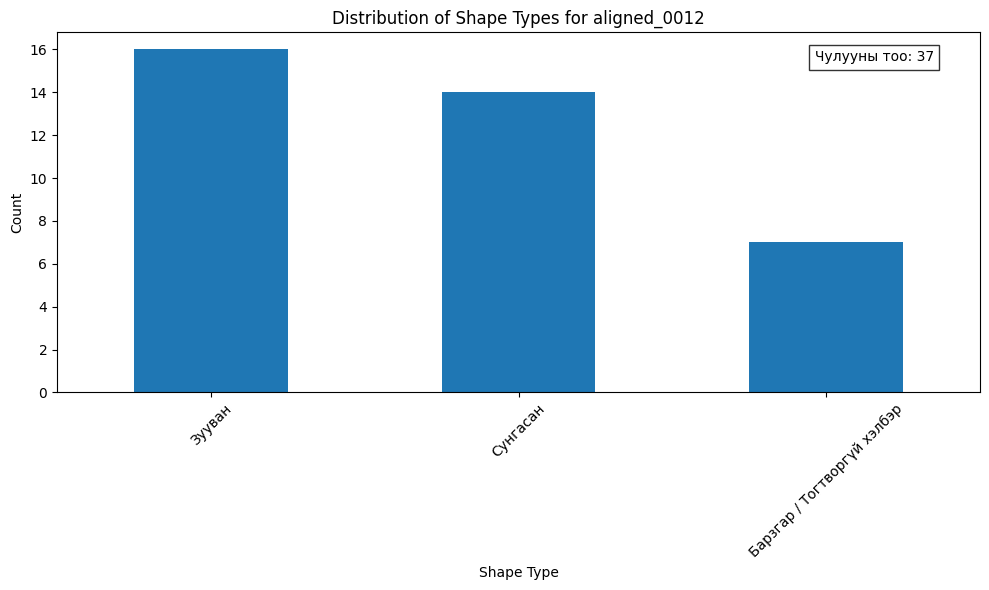

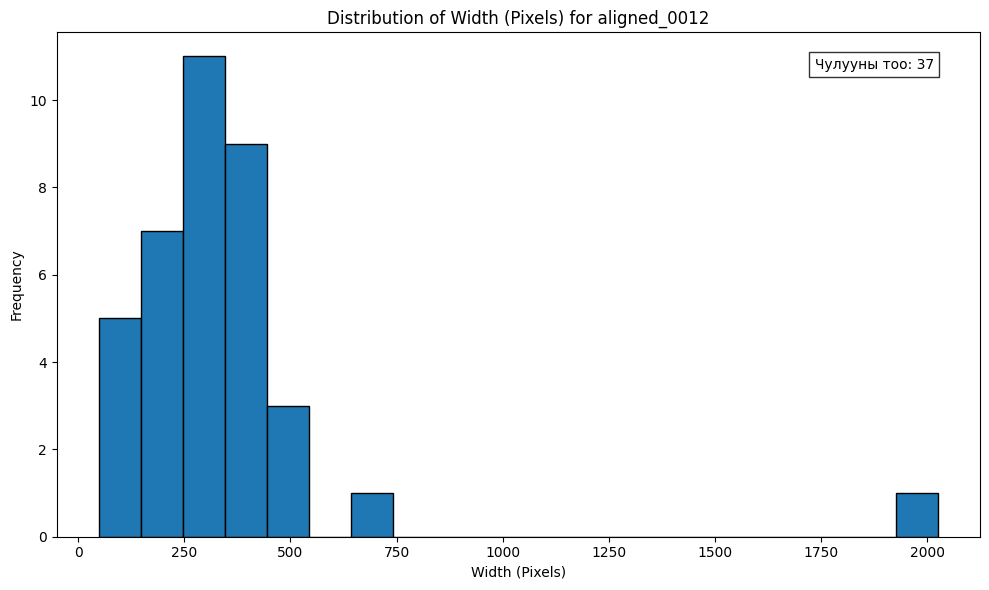

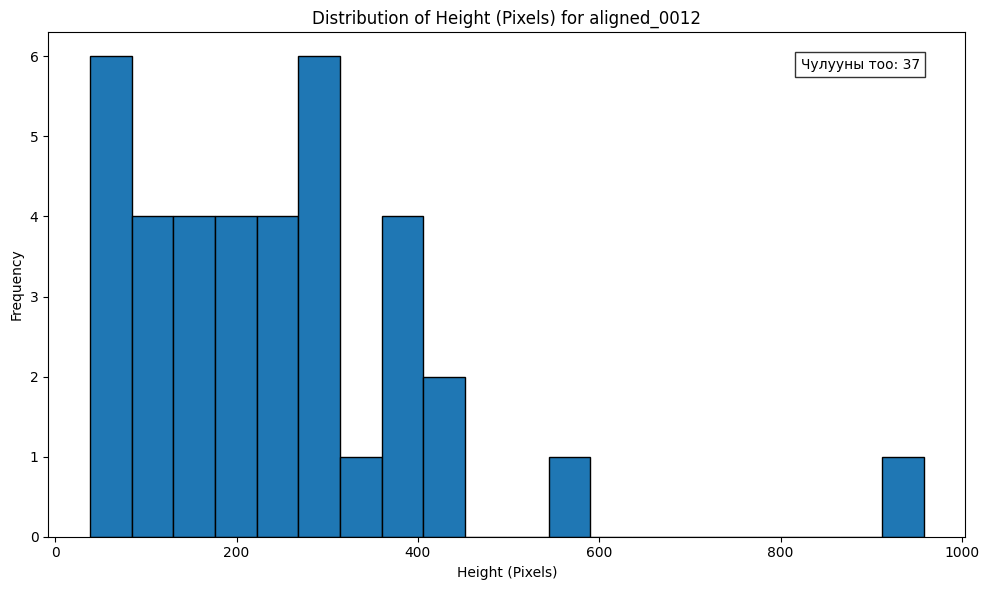

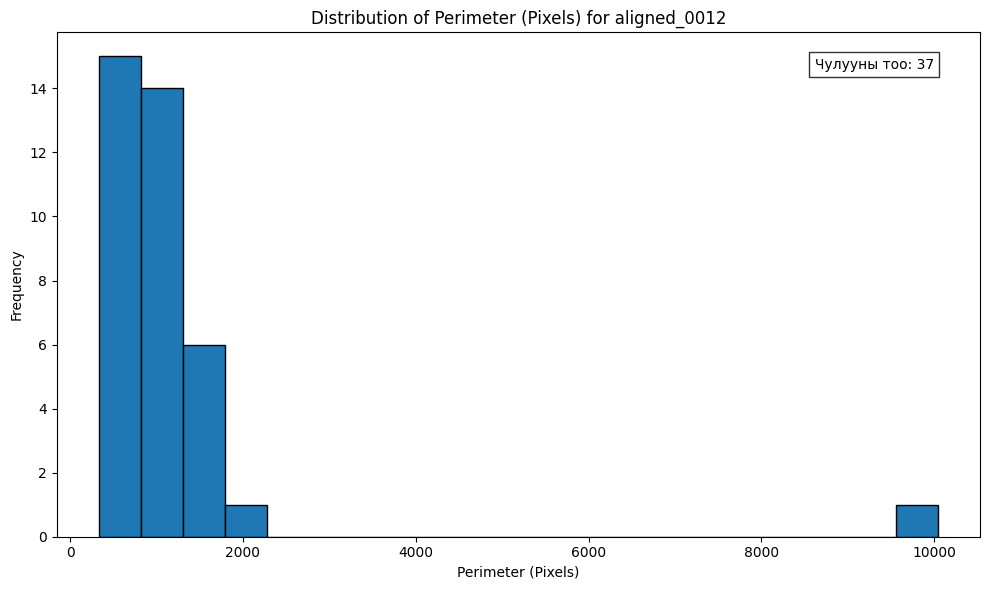

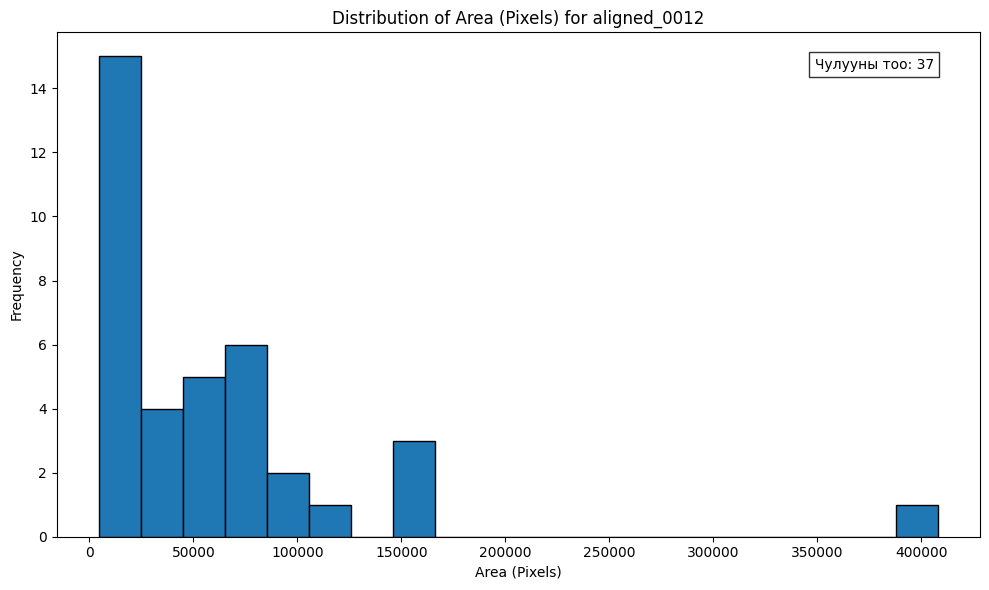

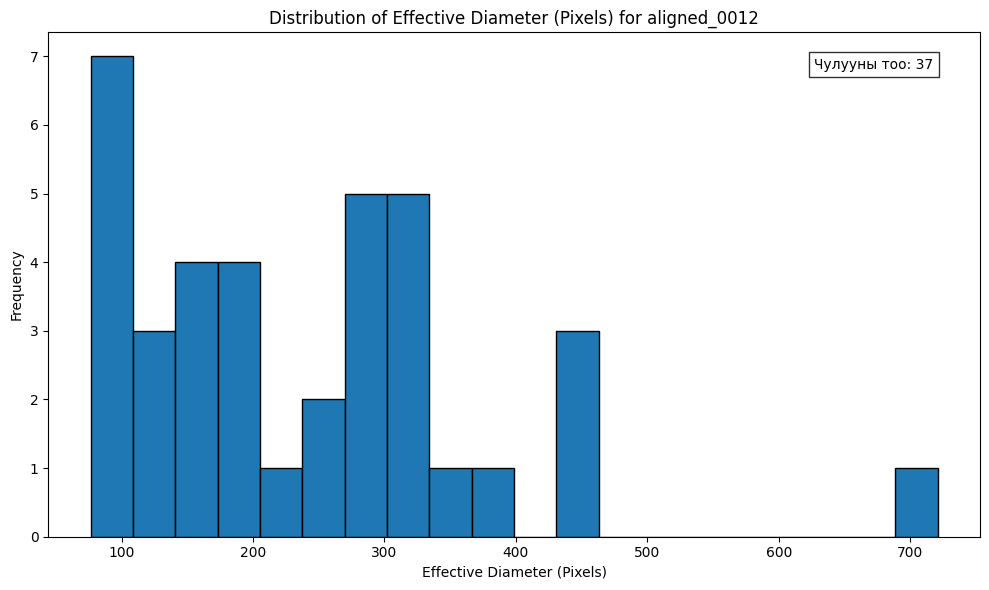

❌ Error processing aligned_0012.jpg: name 'gc' is not defined
🔄 Processing image 5/5: aligned_0013.jpg
Generated 77 raw masks for aligned_0013.jpg
Mask 1 area: 82452 pixels
Mask 2 area: 158899 pixels
Mask 3 area: 62693 pixels
Mask 4 area: 69163 pixels
Mask 5 area: 65146 pixels
Mask 6 area: 78624 pixels
Mask 7 area: 149604 pixels
Mask 8 area: 63754 pixels
Mask 9 area: 159947 pixels
Mask 10 area: 50940 pixels
Mask 11 area: 45431 pixels
Mask 12 area: 120153 pixels
Mask 13 area: 24678 pixels
Mask 14 area: 88537 pixels
Mask 15 area: 434679 pixels
Mask 16 area: 50957 pixels
Mask 17 area: 151617 pixels
Mask 18 area: 33550 pixels
Mask 19 area: 65299 pixels
Mask 20 area: 149990 pixels
Mask 21 area: 64350 pixels
Mask 22 area: 76674 pixels
Mask 23 area: 79794 pixels
Mask 24 area: 14017 pixels
Mask 25 area: 84425 pixels
Mask 26 area: 23241 pixels
Mask 27 area: 28425 pixels
Mask 28 area: 11360 pixels
Mask 29 area: 88974 pixels
Mask 30 area: 161060 pixels
Mask 31 area: 83789 pixels
Mask 32 area: 712

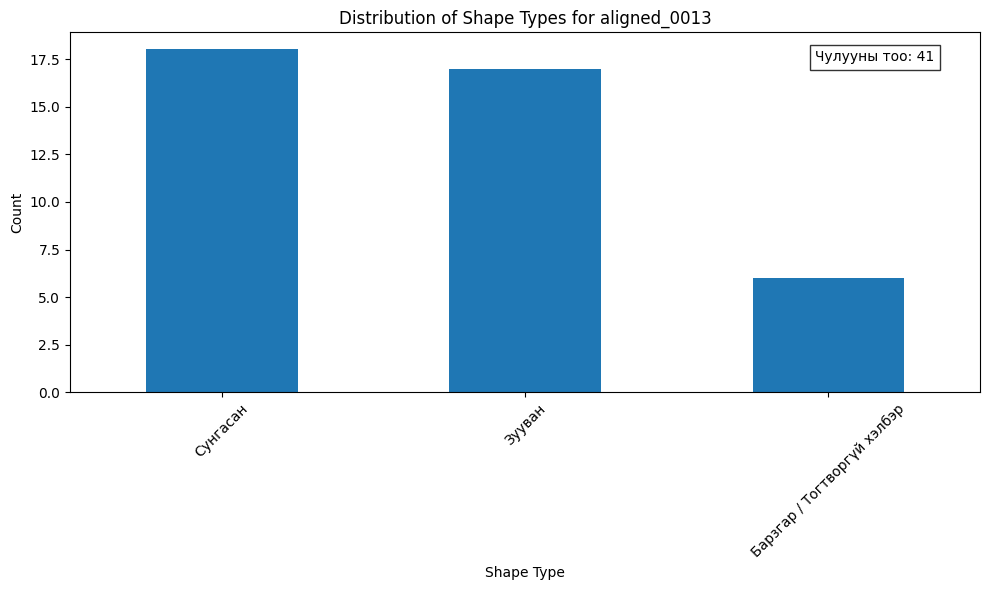

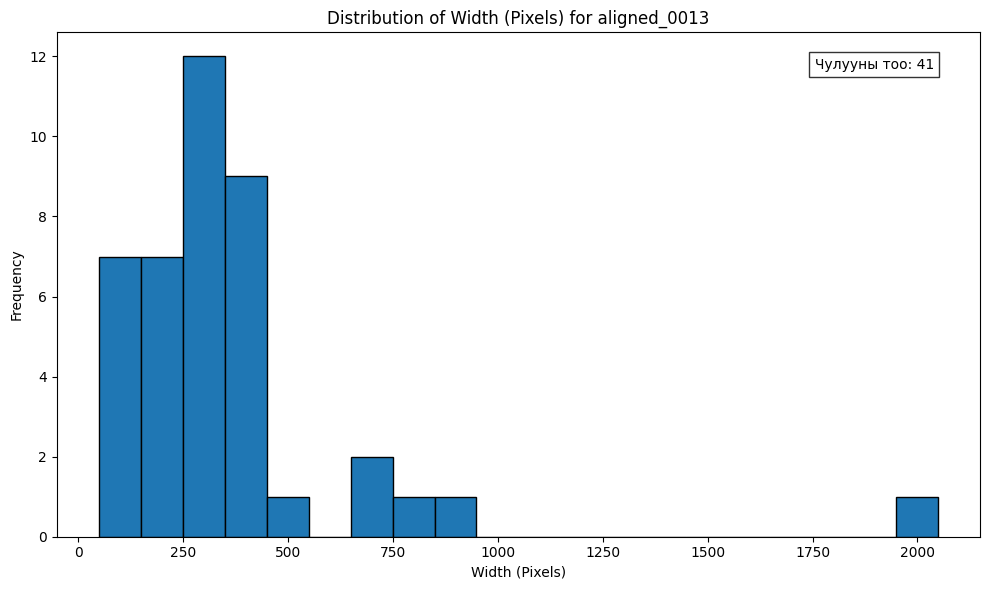

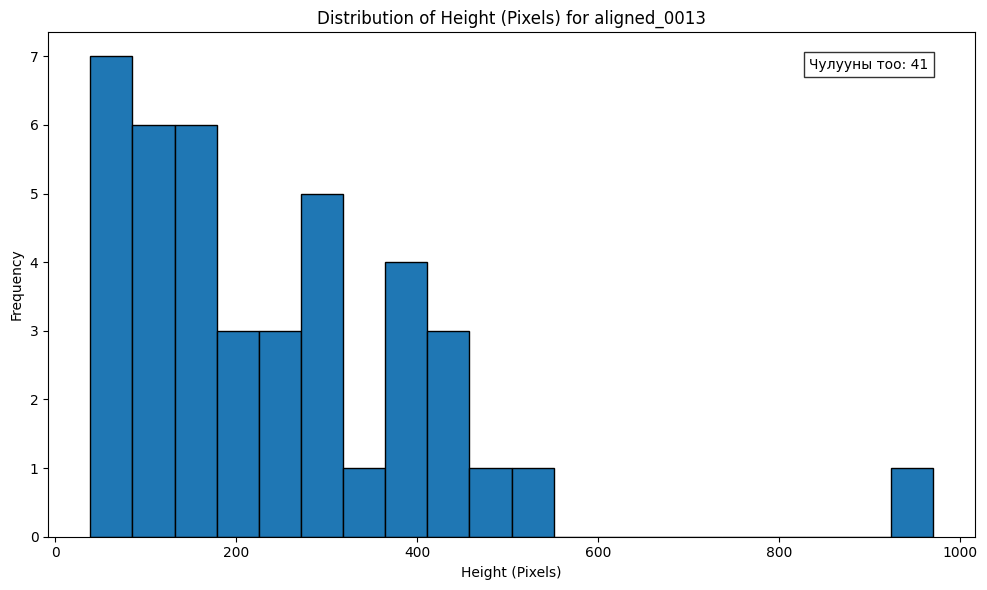

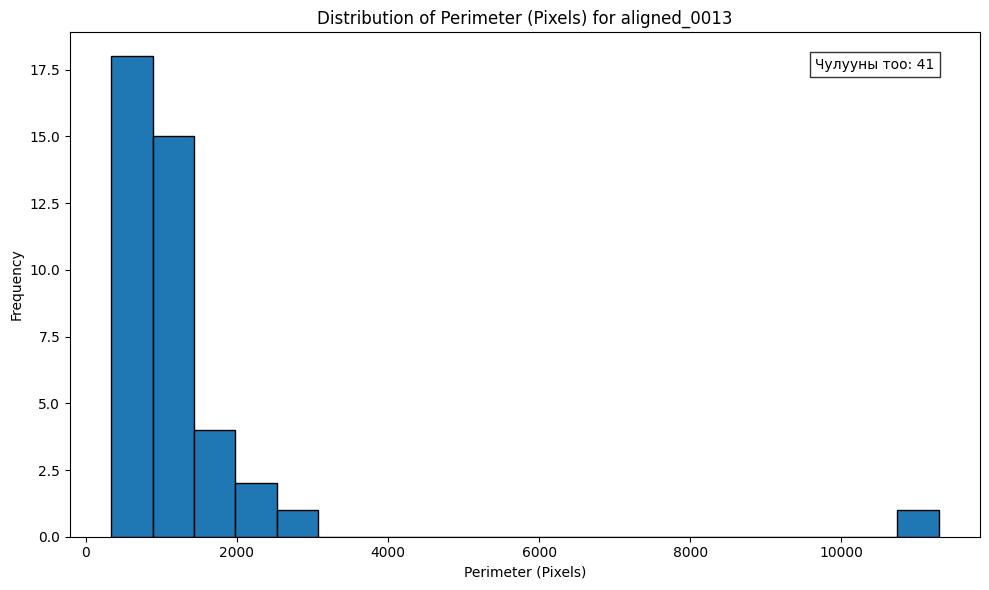

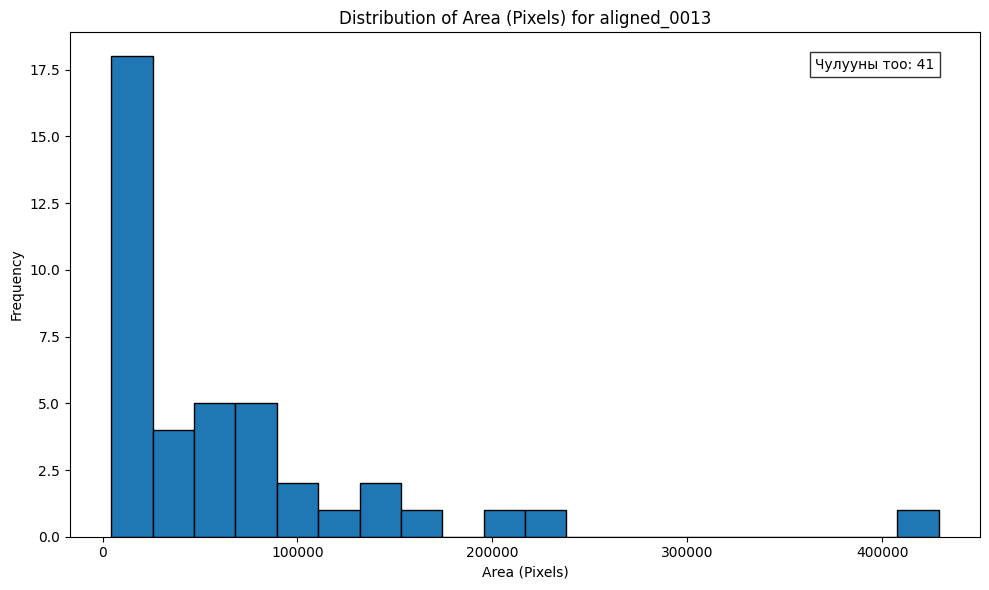

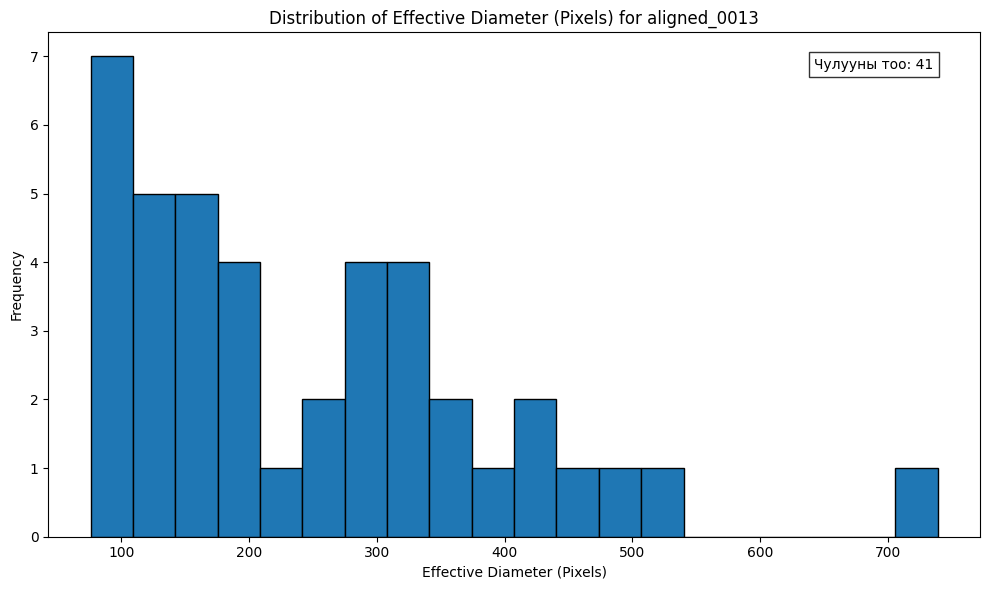

❌ Error processing aligned_0013.jpg: name 'gc' is not defined
🎉 Finished processing all images.


In [17]:
def main():
    try:
        from google.colab import drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        else:
            print("✅ Google Drive is already mounted.")
    except Exception as e:
        print(f"⚠️ Warning: Failed to mount Google Drive: {e}")
        print("Proceeding without Google Drive. Please upload the video directly to Colab.")

    video_path = "/content/chuluu_bichleg.mp4"
    frames_folder = "/content/frames"
    aligned_folder = "/content/aligned_frames"
    csv_output_folder = "/content/csvs"

    os.makedirs(csv_output_folder, exist_ok=True)

    real_green_width_mm = 350
    real_green_height_mm = 180

    if not os.path.isfile(video_path):
        print(f"⚠️ Video file {video_path} not found. Please upload the video.")
        uploaded = files.upload()
        if 'chuluu_bichleg.mp4' not in uploaded:
            print("❌ Error: Uploaded file is not 'chuluu_bichleg.mp4'. Exiting.")
            return

    saved_count = extract_frames(video_path, frames_folder)
    if saved_count == 0:
        print("❌ No frames extracted. Exiting.")
        return

    os.makedirs(aligned_folder, exist_ok=True)
    image_files = sorted([f for f in os.listdir(frames_folder) if f.endswith((".jpg", ".png"))])
    saved_count = 0

    for idx, fname in enumerate(image_files):
        path = os.path.join(frames_folder, fname)
        image = cv2.imread(path)
        warped_image = warp_green_frame(image, real_green_width_mm, real_green_height_mm)
        if warped_image is not None:
            save_path = os.path.join(aligned_folder, f"aligned_{idx:04d}.jpg")
            cv2.imwrite(save_path, warped_image)
            saved_count += 1
        else:
            print(f"⚠️ {fname} дээр ногоон хүрээ илрээгүй тул хадгалаагүй.")

    print(f"✅ Нийт {saved_count}/{len(image_files)} зураг тэгшлээд хадгаллаа.")

    aligned_images = sorted([f for f in os.listdir(aligned_folder) if f.lower().endswith((".jpg", ".png"))])
    print(f"📸 Total images to process in aligned_folder: {len(aligned_images)}")

    for idx, filename in enumerate(aligned_images):
        print(f"🔄 Processing image {idx + 1}/{len(aligned_images)}: {filename}")
        try:
            image_path = os.path.join(aligned_folder, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"❌ Failed to read image: {filename}")
                continue

            height, width = image.shape[:2]
            pixel_to_mm_ratio_width = real_green_width_mm / width
            pixel_to_mm_ratio_height = real_green_height_mm / height

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if automatic_mask_generator_available:
                mask_generator = SamAutomaticMaskGenerator(sam)
                masks = [mask['segmentation'] for mask in mask_generator.generate(image_rgb)]
            else:
                predictor.set_image(image_rgb)
                masks, scores, logits = predictor.predict(point_coords=None, point_labels=None, multimask_output=True)

            measurements = process_and_measure_sam_masks(
                image, masks, pixel_to_mm_ratio_width, pixel_to_mm_ratio_height, image_name=filename
            )

            if measurements:
                csv_filename = os.path.join(csv_output_folder, f"{os.path.splitext(filename)[0]}.csv")
                df = pd.DataFrame(measurements)
                df.to_csv(csv_filename, index=False)
                print(f"✅ Saved measurements for {filename} to {csv_filename}")
                # Generate plots for this CSV
                plot_distributions_for_csv(csv_filename, csv_output_folder)
            else:
                print(f"⚠️ No valid masks for {filename}, no CSV saved.")

            gc.collect()
            torch.cuda.empty_cache()
            time.sleep(1)

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            continue

    print("🎉 Finished processing all images.")

if __name__ == "__main__":
    main()

In [ ]:
# GitHub руу код байрлуулахад тохиргоо хийх
!git config --global user.email "youremail@example.com"  # Таны имэйл
!git config --global user.name "Your Name"  # Таны нэр

# Репозитори руу түлхэх
!git init
!git remote add origin https://github.com/your-username/your-repository.git  # Танай репозиториын холбоос

# Кодыг GitHub руу түлхэх
!git add .
!git commit -m "Initial commit"
!git push -u origin master